In [2]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#import data from yahoo finance via pandas_datareader
df = web.DataReader('AOT.BK', data_source= 'yahoo', end='2021-08-11')

RemoteDataError: ignored

In [ ]:
df

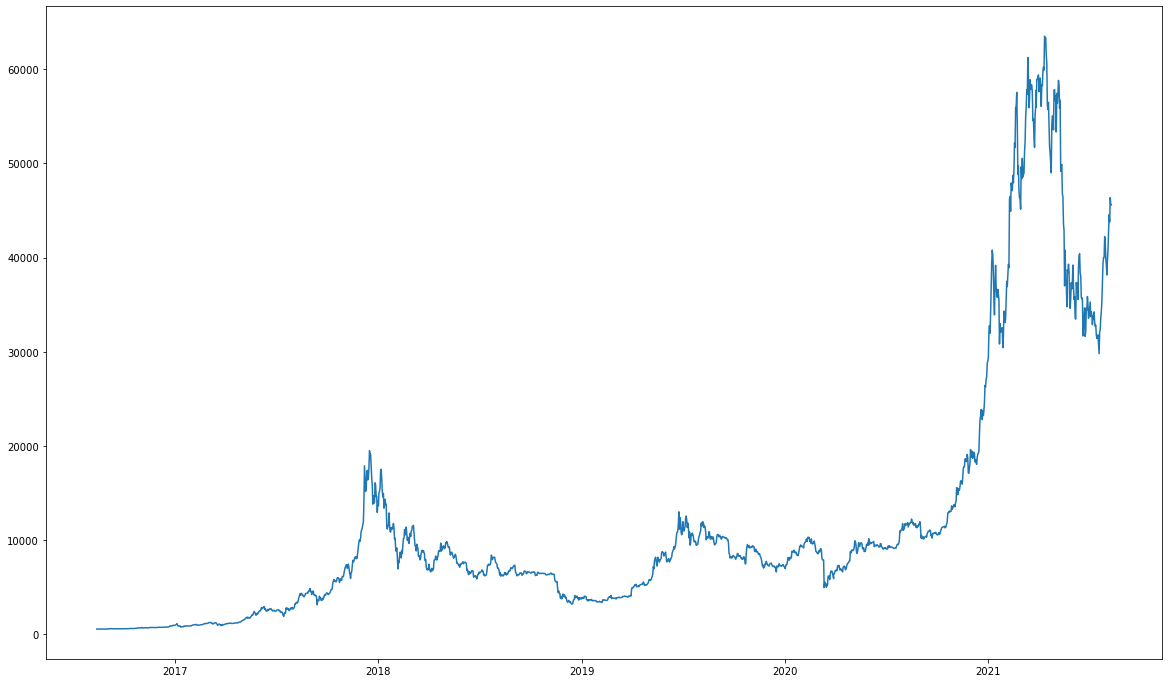

In [ ]:
#visualize close price
plt.figure(figsize = (20,12))
plt.plot(df['Adj Close'])

In [ ]:
X = df.iloc[:,-1].values
y = df.iloc[:,-1].values

In [ ]:
#train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

In [ ]:
#standardize the data
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train.reshape(-1,1))
X_test = X_scaler.transform(X_test.reshape(-1,1))

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1,1))
y_test = y_scaler.transform(y_test.reshape(-1,1))

In [ ]:
#define params
input_size = 1 #num of features
hidden_size = 50 #Hyperparameter
num_layer = 2 #num of LSTM layers
output_size = 1 #predicting 1 data point at a time
batch_size = 1
num_epoch = 20
timestep = 60

In [ ]:
#split train data into mini-batch in torch.tensor format
X_train_data = []
y_train_data = []
for i in range(timestep, len(X_train)):
    X_train_data.append(X_train[i-timestep:i])
    y_train_data.append(y_train[i])


# train_data
X_train_data = torch.DoubleTensor(X_train_data)
y_train_data = torch.DoubleTensor(y_train_data)

LSTM

In [ ]:
#define class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layer, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layer, batch_first= True) #lstm layer
        self.linear = nn.Linear(hidden_size, output_size) #output layer
        
    def forward(self, X, state_in):
        out, state_out = self.lstm(X, state_in)
        out = self.linear(out[:,-1,:])
        return out, state_out

In [ ]:
#define object
lstm = LSTM(input_size, hidden_size, num_layer, output_size).double()
lstm

LSTM(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
#define loss_fn
loss_fn = nn.MSELoss()
loss_fn

MSELoss()

In [ ]:
#define optimizer
optimizer = torch.optim.Adam(lstm.parameters(), lr= 0.0001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

In [ ]:
#model training
loss_hist = np.zeros(num_epoch)
for epoch in range(num_epoch):
    #initialize hidden and cell state of lstm to zeros tensor
    state_in = (torch.zeros(num_layer, batch_size, hidden_size).double(),
                torch.zeros(num_layer, batch_size, hidden_size).double()
               )
    
    for i in range(X_train_data.size(0)):
        inputs = X_train_data[i].view(1,timestep,1)
        targets = y_train_data[i]
        #forward propagation
        output, _ = lstm.forward(inputs.double(), state_in)
        #calculate MSELoss
        loss = loss_fn(output.view(1), targets)
        #backpropagation
        optimizer.zero_grad()
        loss.backward()
        #weight update
        optimizer.step()
        
    loss_hist[epoch] = loss
    print('Epoch: [{}/{}]\t\t Loss: {:.4f}'
          .format(epoch+1, num_epoch, loss))

Epoch: [1/20]		 Loss: 0.1175
Epoch: [2/20]		 Loss: 0.1102
Epoch: [3/20]		 Loss: 0.0780
Epoch: [4/20]		 Loss: 0.0533
Epoch: [5/20]		 Loss: 0.0431
Epoch: [6/20]		 Loss: 0.0377
Epoch: [7/20]		 Loss: 0.0288
Epoch: [8/20]		 Loss: 0.0222
Epoch: [9/20]		 Loss: 0.0169
Epoch: [10/20]		 Loss: 0.0088
Epoch: [11/20]		 Loss: 0.0056
Epoch: [12/20]		 Loss: 0.0031
Epoch: [13/20]		 Loss: 0.0026
Epoch: [14/20]		 Loss: 0.0027
Epoch: [15/20]		 Loss: 0.0034
Epoch: [16/20]		 Loss: 0.0000
Epoch: [17/20]		 Loss: 0.0000
Epoch: [18/20]		 Loss: 0.0002
Epoch: [19/20]		 Loss: 0.0002
Epoch: [20/20]		 Loss: 0.0002


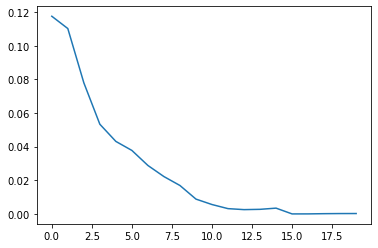

In [ ]:
plt.plot(loss_hist)

In [ ]:
state_in = (torch.zeros(num_layer, batch_size, hidden_size).double(),
            torch.zeros(num_layer, batch_size, hidden_size).double()
           )

train_pred = []

for i in range(X_train_data.size(0)):
    inputs = X_train_data[i].view(1,timestep,1)
    #forward propagation
    output, _ = lstm.forward(inputs.double(), state_in)
    train_pred.append(output.item())

In [ ]:
#inverse transform
train_pred = list(y_scaler.inverse_transform(train_pred))

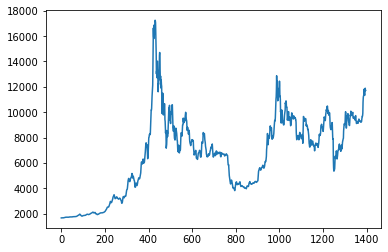

In [ ]:
plt.plot(train_pred)

In [ ]:
#model testing preprocess
X_test_data = []
y_test_data = []
for i in range(timestep, len(X_test)):
    X_test_data.append(X_test[i-timestep:i])
    y_test_data.append(y_test[i])


# test_data
X_test_data = torch.DoubleTensor(X_test_data)
y_test_data = torch.DoubleTensor(y_test_data)

In [ ]:
state_in = (torch.zeros(num_layer, batch_size, hidden_size).double(),
            torch.zeros(num_layer, batch_size, hidden_size).double()
           )

test_pred = []

for i in range(X_test_data.size(0)):
    inputs = X_test_data[i].view(1,timestep,1)
    #forward propagation
    output, _ = lstm.forward(inputs.double(), state_in)
    test_pred.append(output.item())

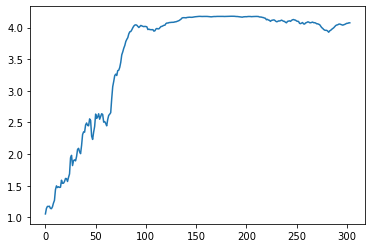

In [ ]:
plt.plot(test_pred)

In [ ]:
#inverse transform
test_pred = list(y_scaler.inverse_transform(test_pred))

In [ ]:
#inverse transform
X_train = X_scaler.inverse_transform(X_train)
X_test = X_scaler.inverse_transform(X_test)

In [ ]:
#shift data
for i in range(len(X_train)+timestep):
    test_pred.insert(0, None)

In [ ]:
#shift data
for i in range(timestep):
    train_pred.insert(0, None)

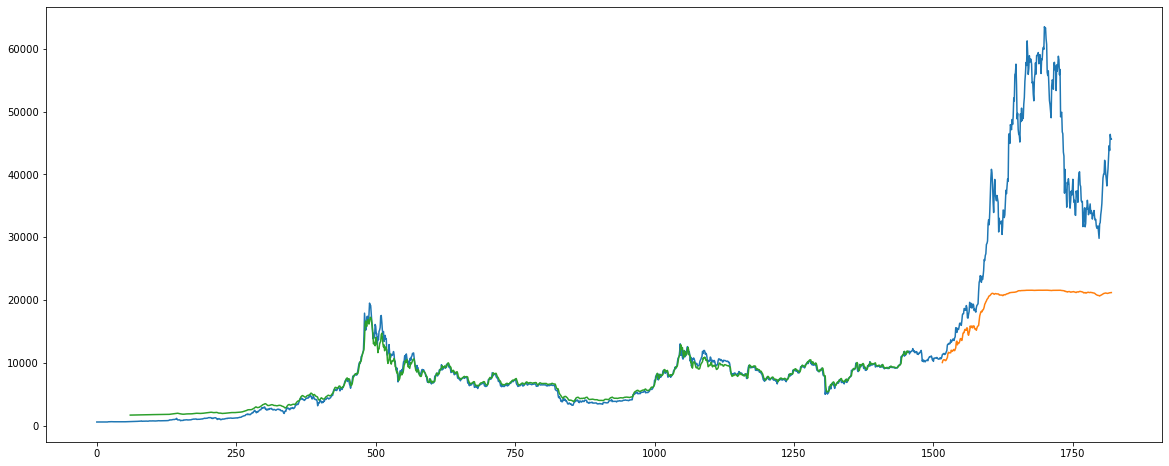

In [ ]:
#visualize result
plt.figure(figsize= (20,8))
plt.plot(np.concatenate((X_train,X_test)))
plt.plot(test_pred)
plt.plot(train_pred)